# ML4Science Examples

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/ML4Science/blob/main/docs/Examples.ipynb)
&nbsp; • &nbsp; [🌐 **ML4Science**](https://github.com/tum-pbs/ML4Science)
&nbsp; • &nbsp; [📖 **Documentation**](https://tum-pbs.github.io/ML4Science/)
&nbsp; • &nbsp; [🔗 **API**](https://tum-pbs.github.io/ML4Science/ml4s)
&nbsp; • &nbsp; [**▶ Videos**]()

All examples listed in this notebook can be run with any of the three supported ML backends: `jax`, `torch` and `tensorflow`.
You can select your preferred one by changing the below `math.use()` call.

In [1]:
# !pip install ml4s
from ml4s import math, nn
from ml4s.math import channel, spatial, batch, instance

math.use('jax')

from matplotlib import pyplot as plt

### Training an MLP

The following script trains an [MLP](https://tum-pbs.github.io/ML4Science/ml4s/nn#ml4s.nn.mlp) with three hidden layers to learn a noisy 1D sine function in the range [-2, 2].

In [2]:
net = nn.mlp(1, 1, layers=[128, 128, 128], activation='ReLU')
optimizer = nn.adam(net, learning_rate=1e-3)

data_x = math.random_uniform(batch(batch=128), low=-2, high=2)
data_y = math.sin(data_x) + math.random_normal(batch(batch=128)) * .2

def loss_function(x, y):
    return math.l2_loss(y - math.native_call(net, x))

for i in range(10):
    loss = nn.update_weights(net, optimizer, loss_function, data_x, data_y)
    print(loss)

(batchᵇ=128) 0.370 ± 0.261 (2e-04...1e+00)
(batchᵇ=128) 0.312 ± 0.223 (9e-05...1e+00)
(batchᵇ=128) 0.248 ± 0.184 (3e-05...8e-01)
(batchᵇ=128) 0.189 ± 0.149 (5e-07...6e-01)
(batchᵇ=128) 0.134 ± 0.116 (2e-05...5e-01)
(batchᵇ=128) 0.088 ± 0.088 (1e-04...4e-01)
(batchᵇ=128) 0.053 ± 0.062 (2e-06...3e-01)
(batchᵇ=128) 0.032 ± 0.039 (8e-06...2e-01)
(batchᵇ=128) 0.031 ± 0.040 (4e-06...2e-01)
(batchᵇ=128) 0.047 ± 0.069 (2e-05...3e-01)


We didn't even have to import `torch` in this example since all calls were routed through ML4Science.
See the [introduction to network training](Networks.html) for more details.

## Simulating the Heat Equation

The heat equation $\partial_t u = \nu \nabla^2 u$ describes heat convection, where $\nu$ denotes the diffusivity and $\nabla^2$ is the laplace operator.
Discretizing $\partial_t u = (u_{t+1} - u_t) / \Delta t$ yields $u_{t+1} = u_t + \Delta t \cdot \nu \nabla^2 u$.
Decorating the function with [`math.jit_compile_linear`](ml4s/math#ml4s.math.jit_compile_linear) makes it run faster as it is compiled to a matrix.

In [3]:
@math.jit_compile_linear
def explicit_heat_step(u, dt, dx, diffusivity):
    return u + dt * diffusivity * math.laplace(u, dx, 'periodic')

Rewriting the above equation to implicit form, we have $u_{t+1} - \Delta t \cdot \nu \nabla^2 u = u_t$.
Notice how this equation looks like a time-reversed explicit step with $u_t$ and $u_{t+1}$ swapped.
This important property is always true for differential equations.

Rewriting the equation to $(1 - \Delta t \cdot \nu \nabla^2) u_{t+1} = u_t$ yields a linear system of equations for $u_{t+1}$.
Advancing the simulation then becomes solving this linear system where the matrix encodes the time-reversed explicit step.
While an implicit step is technically linear, the corresponding matrix would be dense (and typically very large). Therefore, we use [`math.jit_compile`](ml4s/math#ml4s.math.jit_compile) here.

In [4]:
@math.jit_compile
def implicit_heat_step(u, dx, dt, diffusivity):
    return math.solve_linear(explicit_heat_step, u, math.Solve(x0=u), dt=-dt, dx=dx, diffusivity=diffusivity)

Let's run the simulation in 1D.

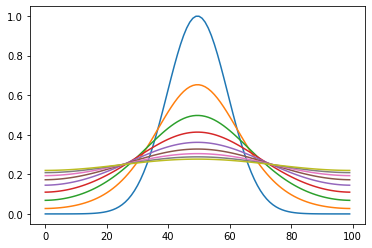

In [5]:
x = math.linspace(0, 1, spatial(x=100))
u0 = math.exp(-.5 * (x-.5) ** 2 / .1 ** 2)
u_trj = math.iterate(implicit_heat_step, batch(t=8), u0, dx=1/100, dt=.01, diffusivity=1.)
plt.plot(u_trj.numpy('x,t'));

Let's run the simulation in 2D. In fact, the simulation works in *n* dimensions.

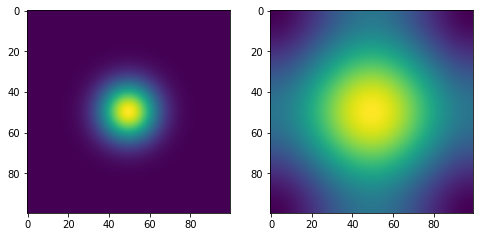

In [6]:
x = math.linspace(0, 1, spatial(x=100, y=100))
u0 = math.exp(-.5 * math.vec_squared(x-.5) / .1 ** 2)
u_trj = math.iterate(implicit_heat_step, batch(t=8), u0, dx=1/100, dt=.01, diffusivity=1.)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(u0.numpy('y,x'))
ax2.imshow(u_trj.t[-1].numpy('y,x'));

## Simulating Burgers' Equation

Burgers' equation $\partial_t u = \nu \nabla^2 u - u \nabla u$ is a convection-diffusion equation.
Notice the non-linear convection term $u \nabla u$.
When writing Burgers' equation as a matrix equation, we need to linearize it.
This can be done by using the previous state for the first $u$ term (Picard 1).

As with the heat equation above, we first write an explicit Euler step.
We use an upwind scheme.

In [7]:
@math.jit_compile_linear
def explicit_burgers(u, u_prev, dt, diffusivity, boundary='periodic'):
    dx = 1 / math.wrap(spatial(u), channel(u))
    left, right = math.shift(u_prev, (-1, 1), padding=boundary, stack_dim=channel('adv'))
    positive_winds = math.maximum(0, (u_prev + left) / 2)
    negative_winds = math.minimum(0, (u_prev + right) / 2)
    forward_diff = math.spatial_gradient(u, dx, 'forward', padding=boundary, stack_dim=channel('adv'))
    backward_diff = math.spatial_gradient(u, dx, 'backward', padding=boundary, stack_dim=channel('adv'))
    advection = math.sum(backward_diff * positive_winds + forward_diff * negative_winds, 'adv')  # sum required for n-d
    diffusion = diffusivity * math.laplace(u, padding=boundary)
    return u + dt * (diffusion - advection)

In [8]:
@math.jit_compile
def implicit_burgers(u_prev, dt, diffusivity=1e-4):
    return math.solve_linear(explicit_burgers, u_prev, math.Solve(x0=u_prev), u_prev=u_prev, dt=-dt, diffusivity=diffusivity)

Let's run the implicit simulation in 1D.

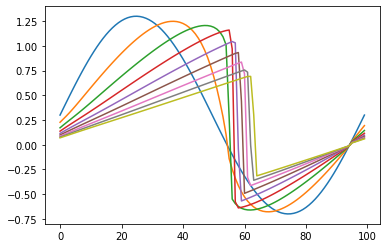

In [9]:
x = math.linspace(0, 1, spatial(x=100))
u0 = math.sin(x * 2 * math.PI) + 0.3
u_trj = math.iterate(implicit_burgers, batch(t=80), u0, dt=0.01)
plt.plot(u_trj.t[::10].numpy('x,t'));

### Pairwise Distances

The following function takes a (possibly batched) tensor of positions and computes the distance matrix.

In [10]:
from ml4s import math  # uses NumPy by default

def pairwise_distances(x: math.Tensor):
    dx = math.rename_dims(x, 'points', 'others') - x
    return math.vec_length(dx)

x = math.random_normal(math.instance(points=3), math.channel(vector="x,y"))
math.print(pairwise_distances(x))

[[0.       , 3.3728998, 1.9318241],
 [3.3728998, 0.       , 1.8491019],
 [1.9318241, 1.8491019, 0.       ]]


Inside `pairwise_distances`, we rename 'points' to 'others'.
When taking the difference, ML4Science automatically expands both operands by the missing dimensions, adding 'points' to the first argument and 'others' to the second.
An explanation of this automatic reshaping is given [here](https://tum-pbs.github.io/ML4Science/Shapes.html).

### Automatic Differentiation

Next, let's compute the [gradient](https://tum-pbs.github.io/ML4Science/Autodiff.html) of some function of *(x,y)* w.r.t. *x*.

In [11]:
from ml4s import math
math.use('jax')

def function(x, y):
    return x ** 2 * y

gradient_x = math.gradient(function, wrt='x', get_output=False)
print(gradient_x(2, 1))

4.0


/home/holl/PycharmProjects/UnifyML/ml4s/math/_functional.py:475: RuntimeWarning: Using jax for gradient computation because numpy does not support jacobian()
  warnings.warn(f"Using {math.default_backend()} for gradient computation because {key.backend} does not support jacobian()", RuntimeWarning)


### JIT compilation

ML4Science provides two types of [JIT compilation](https://tum-pbs.github.io/ML4Science/JIT.html): the generic [`jit_compile`](https://tum-pbs.github.io/ML4Science/ml4s/math#ml4s.math.jit_compile) calls the corresponding library function while [`jit_compile_linear`](https://tum-pbs.github.io/ML4Science/ml4s/math#ml4s.math.jit_compile_linear) builds an [explicit representation for linear functions](https://tum-pbs.github.io/ML4Science/Matrices.html#Tracing).

In [12]:
from ml4s import math
math.use('tensorflow')

@math.jit_compile(auxiliary_args='divide_by_y')
def function(x, y, divide_by_y=False):
    if divide_by_y:
        return x ** 2 / y
    else:
        return x ** 2 * y

function(math.tensor(2), 2, False)

8

Here, we declare `divide_by_y` as an auxiliary argument to force the function to be re-traced when its value changes.
Otherwise, its concrete value would not be available inside the function and could not be used within an `if` clause.

JIT compilation of linear functions is also supported on NumPy.

In [13]:
from ml4s import math
math.use('numpy')

@math.jit_compile_linear(auxiliary_args='compute_laplace')
def optional_sp_grad(x, compute_gradient):
    if compute_gradient:
        return math.spatial_gradient(x)
    else:
        return -x

optional_sp_grad(math.linspace(0, 1, math.spatial(x=10)), True)

(xˢ=10, gradientᶜ=x) 0.100 ± 0.022 (6e-02...1e-01)

Here, an [explicit sparse matrix representation](https://tum-pbs.github.io/ML4Science/Matrices.html#Tracing) of `optional_sp_grad` is computed each time a new value of `compute_gradient` is passed.


### Solving a sparse linear system with preconditioners

ML4Science supports [solving dense as well as sparse linear systems](https://tum-pbs.github.io/ML4Science/Linear_Solves.html) and can [build an explicit matrix representation from linear Python functions](https://tum-pbs.github.io/ML4Science/Matrices.html) in order to compute preconditioners.
We recommend using ML4Science's tensors, but you can pass native tensors to [`solve_linear()`](https://tum-pbs.github.io/ML4Science/ml4s/math#ml4s.math.solve_linear) as well.
The following example solves the 1D Poisson problem ∇x = b with b=1 with incomplete LU decomposition.

In [14]:
from ml4s import math
import numpy as np

def laplace_1d(x):
    return math.pad(x[1:], (0, 1)) + math.pad(x[:-1], (1, 0)) - 2 * x

b = np.ones((6,))
solve = math.Solve('scipy-CG', rel_tol=1e-5, x0=0*b, preconditioner='ilu')
sol = math.solve_linear(math.jit_compile_linear(laplace_1d), b, solve)

/home/holl/miniconda3/envs/phiflow-dev/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:553: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  warn('CSR matrix format is required. Converting to CSR matrix.',


Decorating the linear function with [`math.jit_compile_linear`](https://tum-pbs.github.io/ML4Science/ml4s/math#ml4s.math.jit_compile_linear) lets ML4Science compute the sparse matrix inside [`solve_linear()`](https://tum-pbs.github.io/ML4Science/ml4s/math#ml4s.math.solve_linear). In this example, the matrix is a tridiagonal band matrix.
Note that if you JIT-compile the [`math.solve_linear()`](https://tum-pbs.github.io/ML4Science/ml4s/math#ml4s.math.solve_linear) call, the sparsity pattern and incomplete LU preconditioner are [computed at JIT time](https://tum-pbs.github.io/ML4Science/NumPy_Constants.html).
The L and U matrices then enter the computational graph as constants and are not recomputed every time the function is called.

## Average of Neighbor Cells

With ML4Science, you can write functions that [work in any number of spatial dimensions](N_Dimensional.html).
The function `neighbor_mean` computes the average of all direct neighbor cells (2 in 1D, 4 in 2D, 6 in 3D).
We can inspect the derived factors by printing the function as a matrix.


In [15]:
def neighbor_mean(grid):
    left, right = math.shift(grid, (-1, 1), padding=math.extrapolation.PERIODIC)
    return math.mean([left, right], math.non_spatial)

math.print(math.matrix_from_function(neighbor_mean, math.zeros(math.spatial(x=5)))[0])

x=0     0.   0.5  0.   0.   0.5  along ~x
x=1     0.5  0.   0.5  0.   0.   along ~x
x=2     0.   0.5  0.   0.5  0.   along ~x
x=3     0.   0.   0.5  0.   0.5  along ~x
x=4     0.5  0.   0.   0.5  0.   along ~x


## Further Reading

Check out the [🚀 quickstart guide](Introduction.html) for an introduction into [tensors](Tensors.html) and [dimensions](Shapes.html).

[🌐 **ML4Science**](https://github.com/tum-pbs/ML4Science)
&nbsp; • &nbsp; [📖 **Documentation**](https://tum-pbs.github.io/ML4Science/)
&nbsp; • &nbsp; [🔗 **API**](https://tum-pbs.github.io/ML4Science/ml4s)
&nbsp; • &nbsp; [**▶ Videos**]()